# **Evaluate the capacity of Wilson and Cowan firing-rate model to simulate the biological sound processing captured by fMRI data with machine learning - 2FT features**

This notebook is part of a group project for the Systems Biology masters at Maastricht University.

You can find more details about my capstone project in this [GitHub repository](https://github.com/sayalaruano/Sound_classif_fmri_and_WCfiring_model).

**Dataset description**

This project encompasses two types of data: experimental (fMRI) and modeling (firing activity) datasets. In relation to the experimental dataset, neural responses were measured across brain regions (voxels), in response to 288 auditory stimuli. This data was collected from a cohort of five subjects. The voxels are distributed within the auditory cortex, including core areas (A1 and R) and belt areas (Slow and Fast). The core and belt areas differ in their spectral and temporal information processing.  

The modeling dataset will be obtained using the computational model proposed by  Zulfiqar et al. (2020). This dataset will consist of the firing rates across time and the tonotopic axis of core and belt areas, with each region represented by its own matrix. These matrices will collectively capture the firing activity for the 288 sounds from the experimental dataset.

## **Imports and data obtention**

In [1]:
# Imports
# Data manipulation and EDA
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Machine learning classifers
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

### **Loading experimental and modeling datasets**

In [4]:
# Load modeling dataset 
# model_df = pd.read_csv('modeling_fairingrate_dataset_creation/fr_allsounds.csv', header=None)
X_modelFT2 = np.genfromtxt('modeling_fairingrate_dataset_creation/FT2_features_obtention/fr_allsounds_FT2.csv', delimiter=',')
model_df_col_names = pd.read_csv('modeling_fairingrate_dataset_creation/fr_labels.csv', header= None)

### **Creating target variable**

In [3]:
# Create the target variable vector for both datasets (modeling and experimental)
# 1-48 = "speech", 49-96 = "voice", 97-144 = "animal", 145-192 = "music", 193-240 = "nature", 241-288 = "tool"
categories = {
    range(1, 49): 'speech',
    range(49, 97): 'voice',
    range(97, 145): 'animal',
    range(145, 193): 'music',
    range(193, 241): 'nature',
    range(241, 289): 'tool'
}

y_labels = [value for i in range(1, 289) for key, value in categories.items() if i in key]

y_labels_df = pd.Series(y_labels)

# Encoding the target class label
y = y_labels_df.map({"speech": 0, "voice": 1, "animal": 2, "music": 3, "nature": 4, "tool": 5}).to_numpy()

### **Training-test split**

In [5]:
# Data splitting on test and training for modeling dataset
X_train_modelFT2, X_test_modelFT2, y_train_modelFT2, y_test_modelFT2 = train_test_split(X_modelFT2, y, test_size=0.2, random_state =42, stratify=y)

## **Machine learning models**
According to the summary table presented above, the best classfier for the modeling dataset was random forest classfier and for the experimental dataset the support vector machine. Considering that random forest was the second best classifier for the experimental dataset and that we want to compare the performance of the best classifier for each dataset, we will use this algorithm to evaluate the performance on the test dataset for both datasets. We will evaluate the random forest with the best hyperparameters obtained in the cross-validation process of the previous section.

The best hyperparameters for the random forest classifier for the modeling dataset were:
- n_estimators: 1000
- max_depth: 30
- max_features: log2

The best hyperparameters for the random forest classifier for the experimental dataset were:
- n_estimators: 2000
- max_depth: 10
- max_features: auto

In [6]:
# Implementation of the best models
best_rf_modelFT2 = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=1000, max_depth=30, max_features='log2', random_state=10))

# Fit the best models
best_rf_modelFT2.fit(X_train_modelFT2, y_train_modelFT2)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=30, max_features='log2',
                                        n_estimators=1000, random_state=10))])

### **General performance metrics of the best models**

In [7]:
# Function to calculate performance metrics
def performance_metrics(y, y_pred):
  acc = accuracy_score(y, y_pred)

  bal_acc = balanced_accuracy_score(y, y_pred)

  prec = precision_score(y, y_pred, average = 'weighted')

  recall = recall_score(y, y_pred,  average = 'weighted')

  f1score = f1_score(y, y_pred,  average = 'weighted')

  mcc = matthews_corrcoef(y, y_pred)

  results = [acc, bal_acc, prec, recall, f1score, mcc]

  return results

In [8]:
# Dataset to store performance metrics of test dataset
results_bestmodels_testFT2 = pd.DataFrame(index=range(6),columns=range(0))

# Create indice list
idxs = pd.Index(['Accuracy', 'Balanced accuracy', 'Precision', 
                'Recall', 'F1score', 'MCC'])
# Set indices
results_bestmodels_testFT2.set_index(idxs, inplace=True)

In [9]:
# Predicting values with the best model on test dataset
y_test_pred_modelFT2 = best_rf_modelFT2.predict(X_test_modelFT2)

# Calculate performance metrics of the modeling dataset
results_bestmodels_testFT2["RandomForest_modelingdataset_FT2"] = performance_metrics(y_test_modelFT2, y_test_pred_modelFT2)

In [10]:
# Show the final results
results_bestmodels_testFT2

,RandomForest_modelingdataset_FT2
Accuracy,0.689655
Balanced accuracy,0.698148
Precision,0.700173
Recall,0.689655
F1score,0.686472
MCC,0.630962


In [11]:
# Export results as a csv
results_bestmodels_testFT2.to_csv("Results/Results_best_classifiers_modeling_FT2_dataset.csv")

### **Performance metrics for every class**

In [12]:
# List of class names
class_names = ["speech", "voice", "animal", "music", "nature", "tool"]

# Performance metrics per class of the best model on the modeling dataset
report_per_class_rf_modelFT2 = classification_report(y_true=y_test_modelFT2, y_pred=y_test_pred_modelFT2,
                                                  target_names = class_names, digits=6, output_dict=True)

# Convert the dictionary to a dataframe
report_per_class_rf_model_dfFT2 = pd.DataFrame(report_per_class_rf_modelFT2).transpose()

# Show the results
report_per_class_rf_model_dfFT2

,precision,recall,f1-score,support
speech,0.900000,1.000000,0.947368,9.000000
voice,0.727273,0.888889,0.800000,9.000000
animal,0.461538,0.600000,0.521739,10.000000
music,0.500000,0.400000,0.444444,10.000000
nature,0.857143,0.600000,0.705882,10.000000
tool,0.777778,0.700000,0.736842,10.000000
accuracy,0.689655,0.689655,0.689655,0.689655
macro avg,0.703955,0.698148,0.692713,58.000000
weighted avg,0.700173,0.689655,0.686472,58.000000


In [13]:
# Export results as a csv
report_per_class_rf_model_dfFT2.to_csv("Results/Performance_perclass_rf_modeldataset_FT2.csv")

### **Confusion matrices**

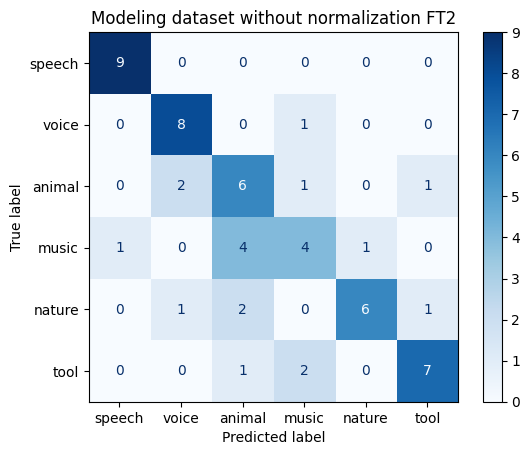

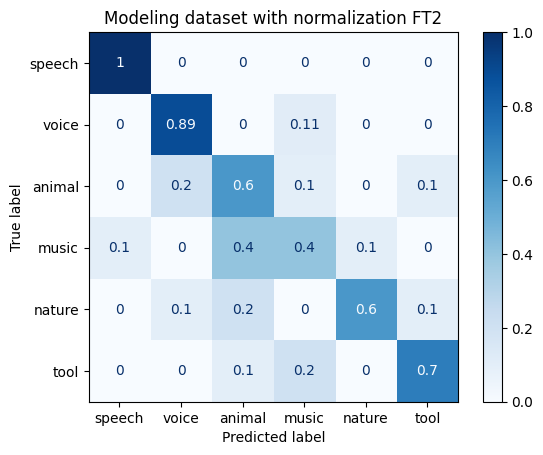

In [14]:
# Create a plot for the confusion matrix of the modeling dataset
titles_options_model = [
    ("Modeling dataset without normalization FT2", None),
    ("Modeling dataset with normalization FT2", "true"),
]
for title, normalize in titles_options_model:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_rf_modelFT2, X_test_modelFT2, y_test_modelFT2,
        display_labels=class_names, cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    
    # Export the plot as a png file
    plt.savefig(f'Results/Confusion_matrix_{title.replace(" ", "_")}.png')

### **ROC curves**

In [15]:
# Calculate the y_score for the modeling and fMRI datasets
y_score_modelFT2 = best_rf_modelFT2.predict_proba(X_test_modelFT2)

# Binarize the outputs
y_test_bin_modelFT2 = label_binarize(y_test_modelFT2, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test_bin_modelFT2.shape[1]

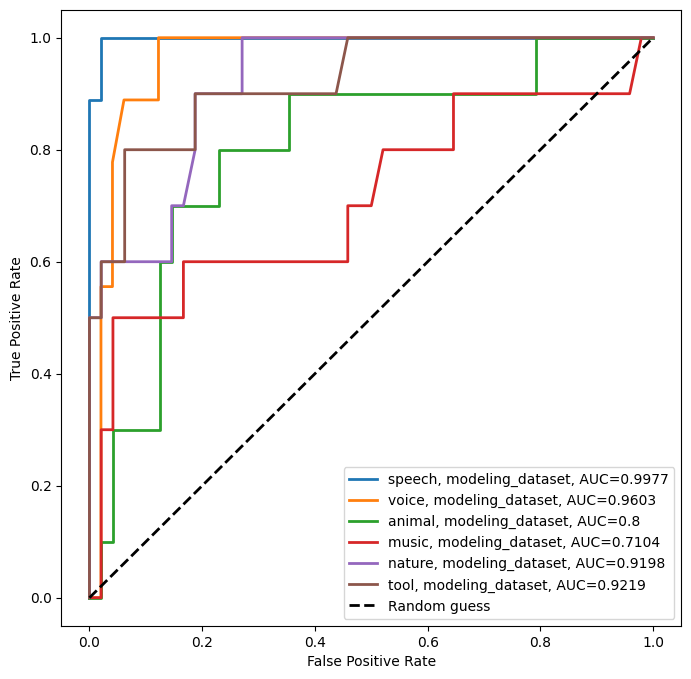

In [16]:
plt.figure(figsize=(8, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_modelFT2[:, i], y_score_modelFT2[:, i])
  auc = round(roc_auc_score(y_test_bin_modelFT2[:, i], y_score_modelFT2[:, i]), 4)
  plt.plot(fpr[i], tpr[i], lw=2, label= class_names[i] + ", modeling_dataset, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('Results/ROC_curve_bestmodel_modelingdataset_FT2.png', bbox_inches='tight')